# Initial Modeling / EDA

The purpose of this notebook is to run initial modeling/EDA of the data in training_horses.pkl.

Importing packages:

In [1]:
import pandas as pd
from importlib import reload
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

## Initial Modeling of the Training Data:

Reading in pickle of the training horses:

In [2]:
training_horses = pd.read_pickle('./Data/training_horses.pkl')

### Initial Modeling of Training Horses - Logistic Regression

First, I want to plot some of the continuous features in my first model table (model_df) for show/no show, to see if there is much class separability:

In [3]:
training_horses.columns

Index(['horse_id', 'horse_type', 'horse_age', 'result', 'draw',
       'declared_weight', 'actual_weight', 'horse_rating', 'distance', 'venue',
       'config', 'horse_ratings', 'Show'],
      dtype='object')

Pairplot to show the features, looking for some separability:

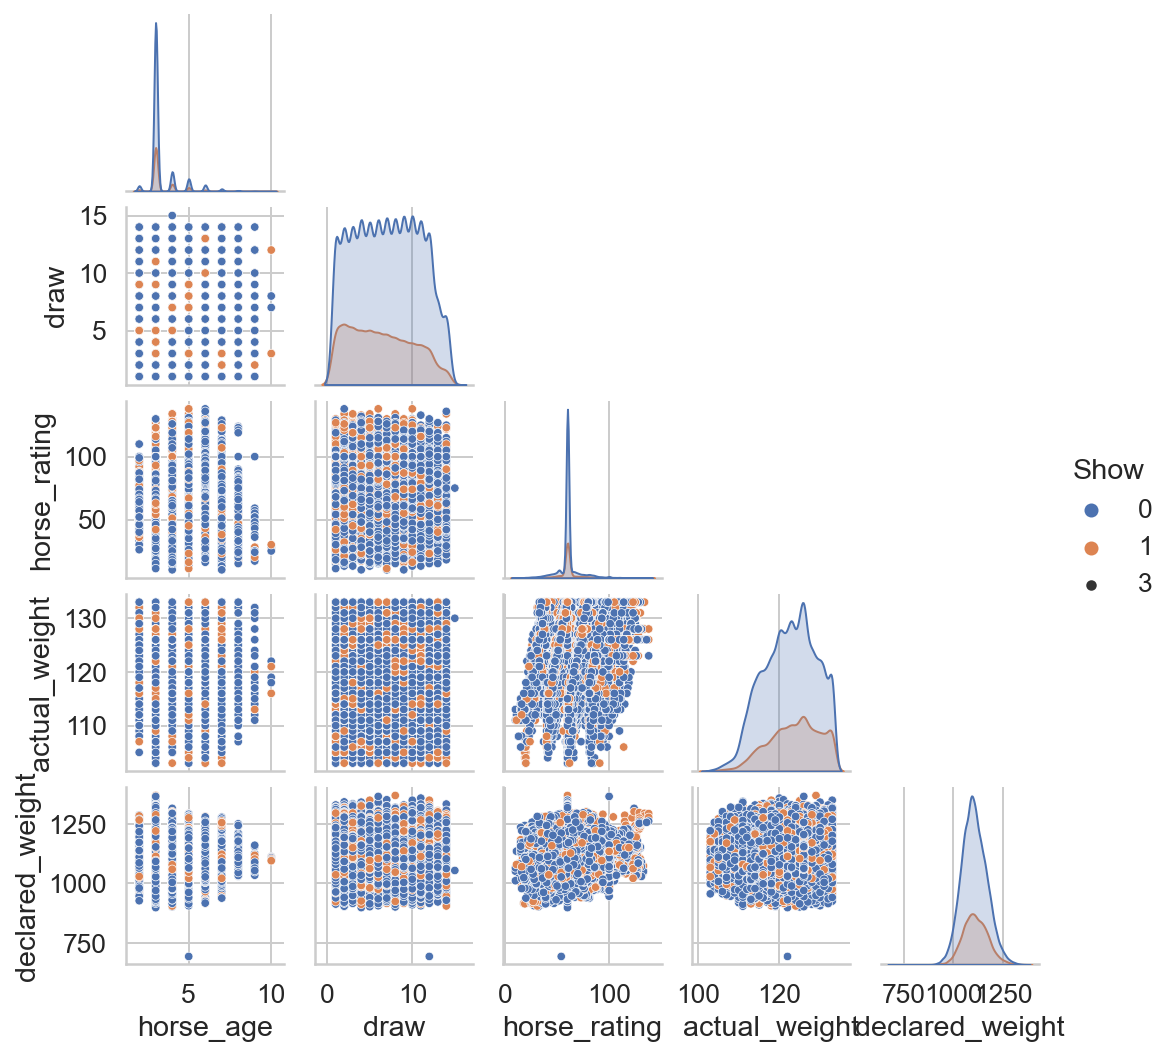

In [4]:
sns.pairplot(training_horses[['horse_age', 'draw', 'horse_rating', 'actual_weight', 'declared_weight', 'Show']], corner=True, height=1.5, plot_kws={'size': 3}, hue='Show');

Not a ton of separability here, draw and actual weight seem to show the most, but it is very little. *(Show is red, non-show is blue)*  

Based on this, I'll do an initial model of actual weight and score via Logistic Regression.

### One Variable Logistic Regression - Actual_weight vs. Show

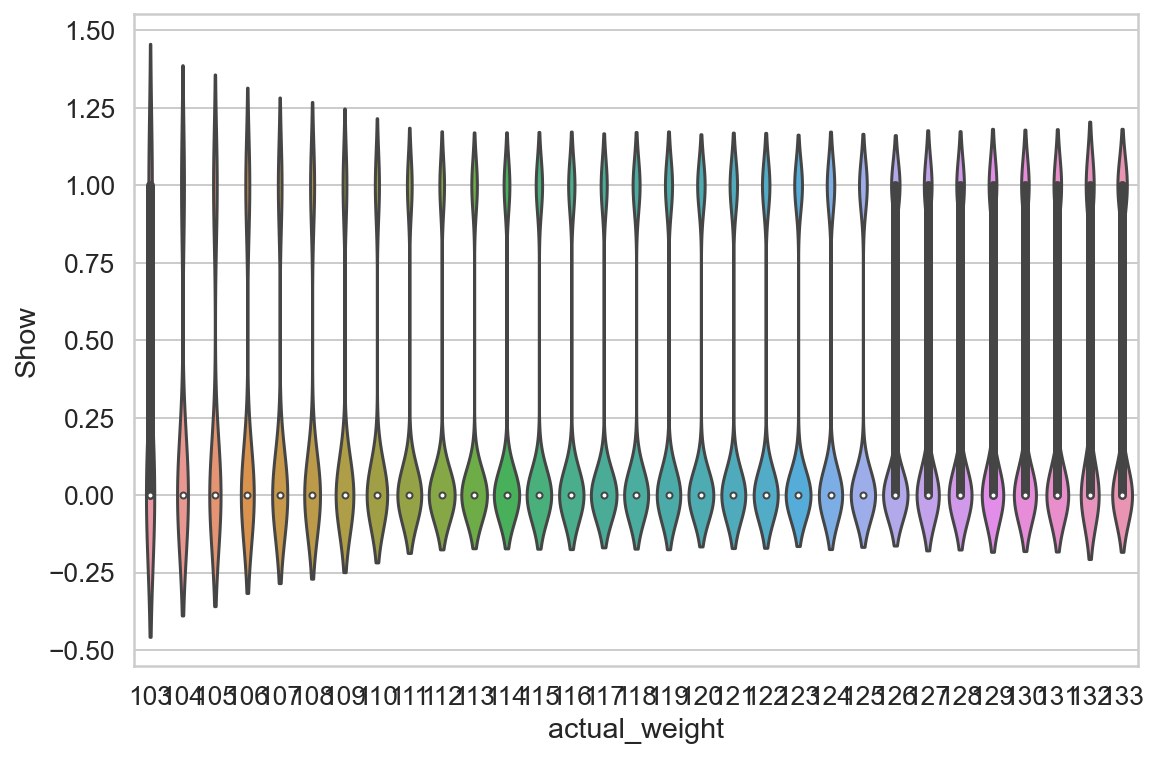

In [6]:
sns.violinplot(x='actual_weight',
               y='Show',
               data=training_horses);

In [7]:
import statsmodels.api as sm

In [8]:
lm_1 = sm.Logit(training_horses['Show'],  # with statsmodels, `y` comes first
                sm.add_constant(training_horses[['actual_weight']]))  # and then `x`

In [9]:
lm_1 = lm_1.fit()

Optimization terminated successfully.
         Current function value: 0.546623
         Iterations 5


In [10]:
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Show   No. Observations:                63228
Model:                          Logit   Df Residuals:                    63226
Method:                           MLE   Df Model:                            1
Date:                Mon, 01 Feb 2021   Pseudo R-squ.:                0.005290
Time:                        20:25:48   Log-Likelihood:                -34562.
converged:                       True   LL-Null:                       -34746.
Covariance Type:            nonrobust   LLR p-value:                 6.097e-82
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.6926      0.186    -25.164      0.000      -5.058      -4.327
actual_weight     0.0287      0.002     19.013      0.000       0.026       0.032
=================================================================================
"""

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
lm_1 = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

#Fitting the model:
lm_1.fit(training_horses[['actual_weight']], training_horses['Show'])

LogisticRegression(C=100000, solver='newton-cg')

### Gender OHE

I do also want to incorporate gender, so I'll do the dummy variables here before scoring a model on logistic regression.

In [13]:
training_model_gender = training_horses.copy()

In [14]:
training_model_gender.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63228 entries, 0 to 79446
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   horse_id         63228 non-null  int64  
 1   horse_type       63226 non-null  object 
 2   horse_age        63228 non-null  int64  
 3   result           63228 non-null  int64  
 4   draw             63228 non-null  int64  
 5   declared_weight  63228 non-null  float64
 6   actual_weight    63228 non-null  int64  
 7   horse_rating     63228 non-null  int64  
 8   distance         63228 non-null  int64  
 9   venue            63228 non-null  object 
 10  config           63228 non-null  object 
 11  horse_ratings    63228 non-null  object 
 12  Show             63228 non-null  int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 8.8+ MB


Only NAN values are in horse_type

In [15]:
training_model_gender.horse_type.value_counts()

Gelding    60250
Brown       1600
Horse        784
Colt         245
Mare         151
Rig           98
Roan          48
Filly         33
Grey          17
Name: horse_type, dtype: int64

**Decision: make horses that say color (Brown, Roan, Grey, or None) as "Gelding", since that is 90% of the horses in the set.**

In [16]:
for i, value in enumerate(training_model_gender['horse_type']):
    if training_model_gender.iloc[i, 1] == 'Brown':
        training_model_gender.iloc[i, 1] = "Gelding"
    elif training_model_gender.iloc[i, 1] == 'Roan':
        training_model_gender.iloc[i, 1] = "Gelding"
    elif training_model_gender.iloc[i, 1] == 'Grey':
        training_model_gender.iloc[i, 1] = "Gelding"

In [17]:
#FIlling in any nan gender values with Gelding, for same rationale above.
training_model_gender.horse_type.fillna(value='Gelding', inplace=True)

In [18]:
training_model_gender.horse_type.value_counts()

Gelding    61917
Horse        784
Colt         245
Mare         151
Rig           98
Filly         33
Name: horse_type, dtype: int64

In [19]:
training_model_gender.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63228 entries, 0 to 79446
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   horse_id         63228 non-null  int64  
 1   horse_type       63228 non-null  object 
 2   horse_age        63228 non-null  int64  
 3   result           63228 non-null  int64  
 4   draw             63228 non-null  int64  
 5   declared_weight  63228 non-null  float64
 6   actual_weight    63228 non-null  int64  
 7   horse_rating     63228 non-null  int64  
 8   distance         63228 non-null  int64  
 9   venue            63228 non-null  object 
 10  config           63228 non-null  object 
 11  horse_ratings    63228 non-null  object 
 12  Show             63228 non-null  int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 8.8+ MB


Ok, sex is cleaned, with no null values.  Time to OHE:

### One Hot Encoding of Gender:

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

In [21]:
ohe = OneHotEncoder(drop='first', sparse=False)

In [22]:
training_model_gender_cat = training_model_gender.loc[:, ['horse_type']]

In [23]:
ohe.fit(training_model_gender_cat)

ohe_X = ohe.transform(training_model_gender_cat)

columns = ohe.get_feature_names(['horse_type'])

ohe_X_df = pd.DataFrame(ohe_X, columns=columns, index=training_model_gender_cat.index)

ohe_X_df.sample(20)

,horse_type_Filly,horse_type_Gelding,horse_type_Horse,horse_type_Mare,horse_type_Rig
37021,0.0,1.0,0.0,0.0,0.0
4184,0.0,1.0,0.0,0.0,0.0
49785,0.0,1.0,0.0,0.0,0.0
56441,0.0,1.0,0.0,0.0,0.0
69485,0.0,1.0,0.0,0.0,0.0
53175,0.0,1.0,0.0,0.0,0.0
51558,0.0,1.0,0.0,0.0,0.0
61945,0.0,1.0,0.0,0.0,0.0
37372,0.0,1.0,0.0,0.0,0.0
38521,0.0,1.0,0.0,0.0,0.0


Now concatenating this back onto the original train df:

In [24]:
comb_training_model_gender = pd.concat([training_model_gender, ohe_X_df], axis=1)

In [25]:
comb_training_model_gender.head()

,horse_id,horse_type,horse_age,result,draw,declared_weight,actual_weight,horse_rating,distance,venue,config,horse_ratings,Show,horse_type_Filly,horse_type_Gelding,horse_type_Horse,horse_type_Mare,horse_type_Rig
0,3917,Gelding,3,10,7,1020.0,133,60,1400,ST,A,40-15,0,0.0,1.0,0.0,0.0,0.0
1,2157,Gelding,3,8,12,980.0,133,60,1400,ST,A,40-15,0,0.0,1.0,0.0,0.0,0.0
3,1853,Gelding,3,9,13,1118.0,127,60,1400,ST,A,40-15,0,0.0,1.0,0.0,0.0,0.0
4,2796,Gelding,3,6,14,972.0,131,60,1400,ST,A,40-15,0,0.0,1.0,0.0,0.0,0.0
5,3296,Gelding,3,3,5,1114.0,127,60,1400,ST,A,40-15,1,0.0,1.0,0.0,0.0,0.0


In [26]:
#Removing original horse_type column:
comb_training_model_gender.drop(columns='horse_type', inplace=True)
comb_training_model_gender.head()

,horse_id,horse_age,result,draw,declared_weight,actual_weight,horse_rating,distance,venue,config,horse_ratings,Show,horse_type_Filly,horse_type_Gelding,horse_type_Horse,horse_type_Mare,horse_type_Rig
0,3917,3,10,7,1020.0,133,60,1400,ST,A,40-15,0,0.0,1.0,0.0,0.0,0.0
1,2157,3,8,12,980.0,133,60,1400,ST,A,40-15,0,0.0,1.0,0.0,0.0,0.0
3,1853,3,9,13,1118.0,127,60,1400,ST,A,40-15,0,0.0,1.0,0.0,0.0,0.0
4,2796,3,6,14,972.0,131,60,1400,ST,A,40-15,0,0.0,1.0,0.0,0.0,0.0
5,3296,3,3,5,1114.0,127,60,1400,ST,A,40-15,1,0.0,1.0,0.0,0.0,0.0


OHE is done, time to model.

# MODEL 1 - INITIAL FEATURES

# KNN and Logistic Regression Accuracy Scoring

I'll need to write functions to cover these:

In [27]:
from sklearn import datasets
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

## KNN Functions in knn_model_eval.py:

Writing a K Next Neighbors function:

In [28]:
from sklearn.metrics import confusion_matrix

In [29]:
from knn_model_eval import *

In [30]:
columns = ['horse_age', 'draw', 'declared_weight', 'actual_weight', 'horse_rating', 'horse_type_Filly', 'horse_type_Gelding', 'horse_type_Horse', 'horse_type_Mare', 'horse_type_Rig' ]

In [31]:
X = comb_training_model_gender[columns]
y = comb_training_model_gender['Show']

The accuracy score for kNN is
Training:  77.45%
Validation set:  73.60%
Validation Set F1 Score: 0.0998:
Validation Set Fbeta Score (beta=0.5): 0.1601
Validation set Precision: 0.2681
Validation set recall: 0.0613 



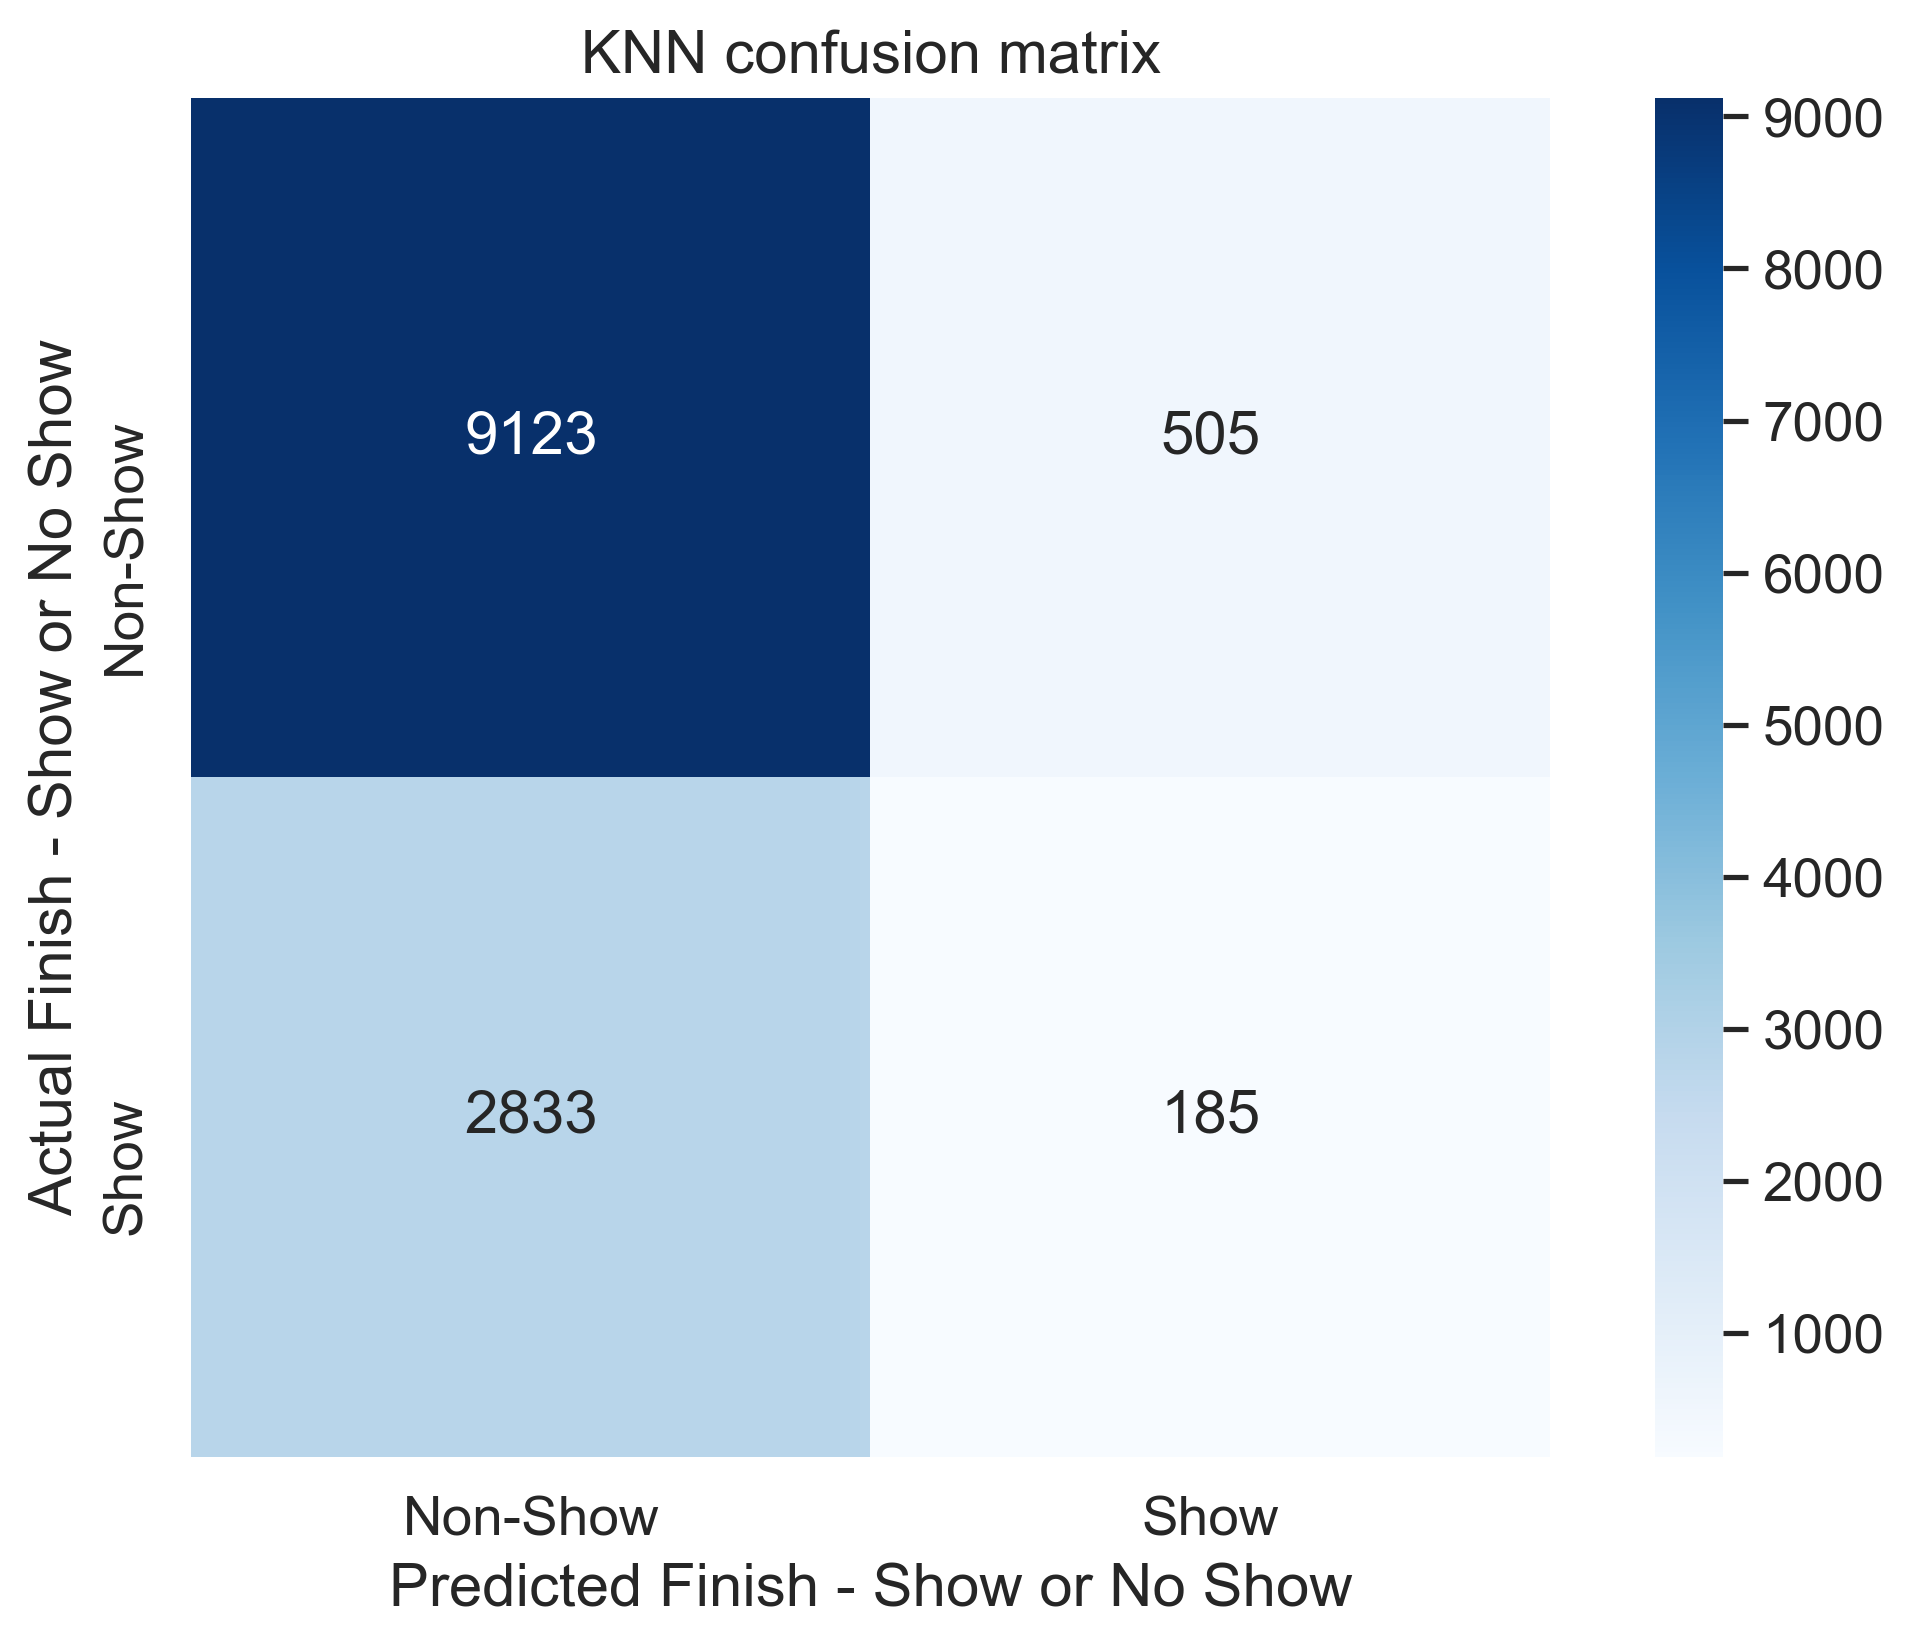

In [32]:
KNN_accuracy_scorer(X, y, n = 9)

## Logistic Regression Functions in logistic_reg_model_eval.py:

In [33]:
from logistic_reg_model_eval import *

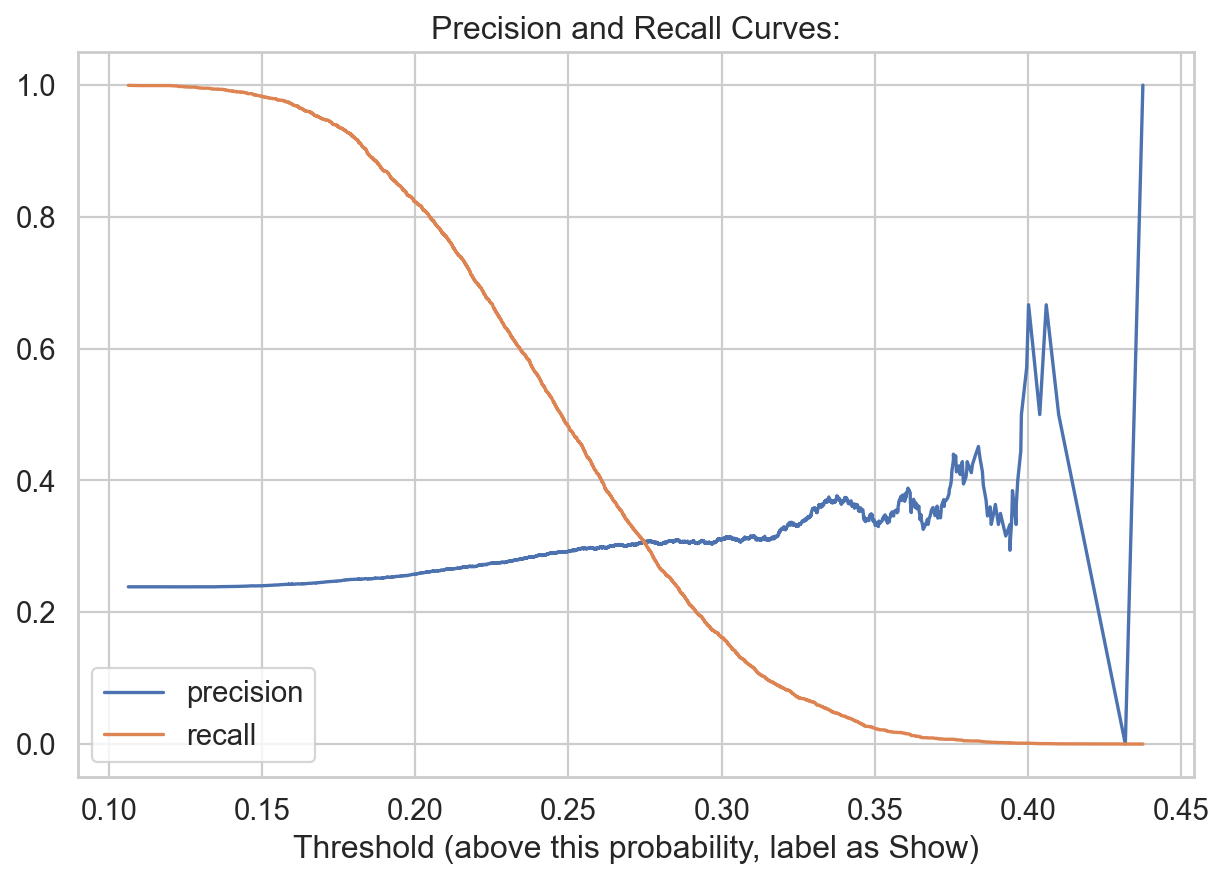

In [34]:
log_precision_and_recall_curves(X,y,C=1)

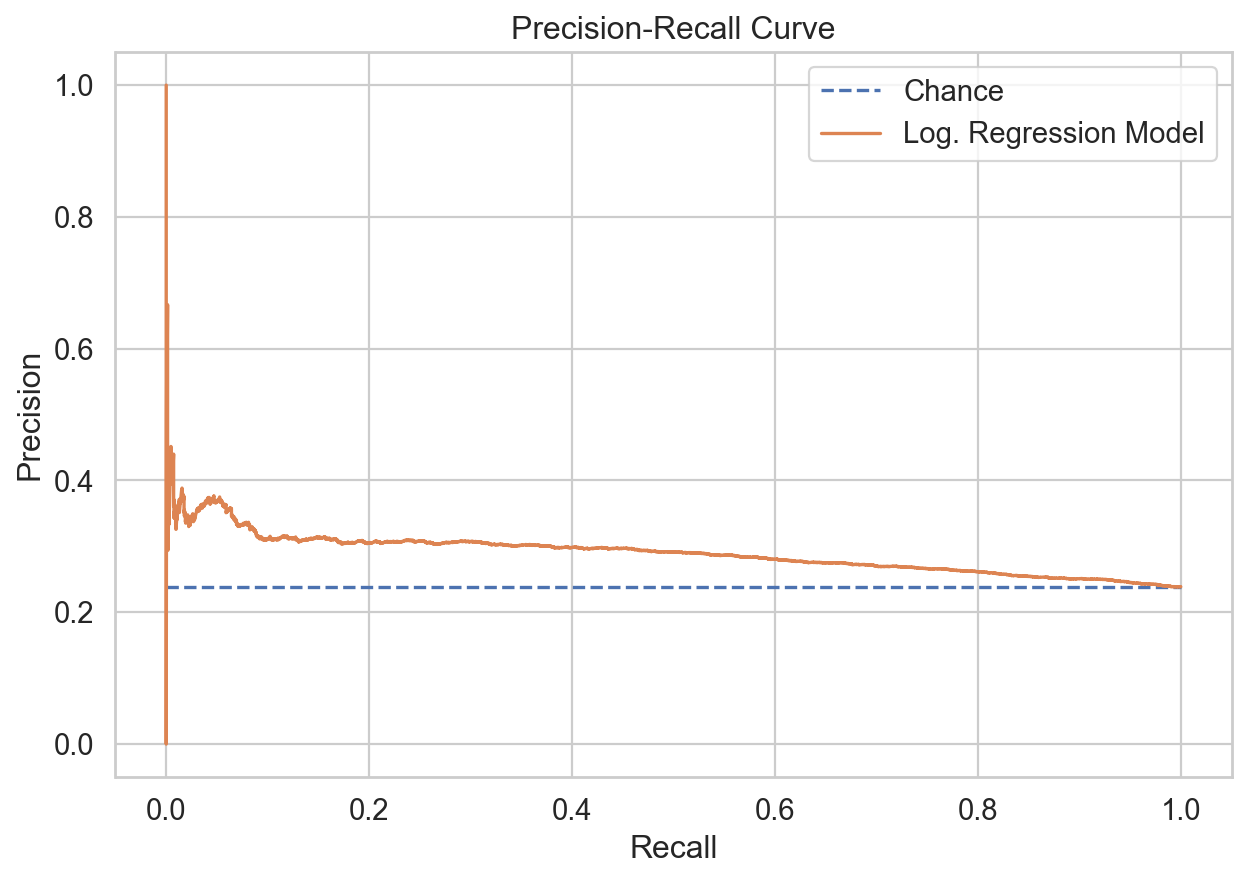

In [35]:
log_precision_recall_curve_generator(X,y,C=1)

ROC AUC score =  0.5786601021209676
Optimal Threshold: 0.2403
Threshold for Max Precision: 0.1064


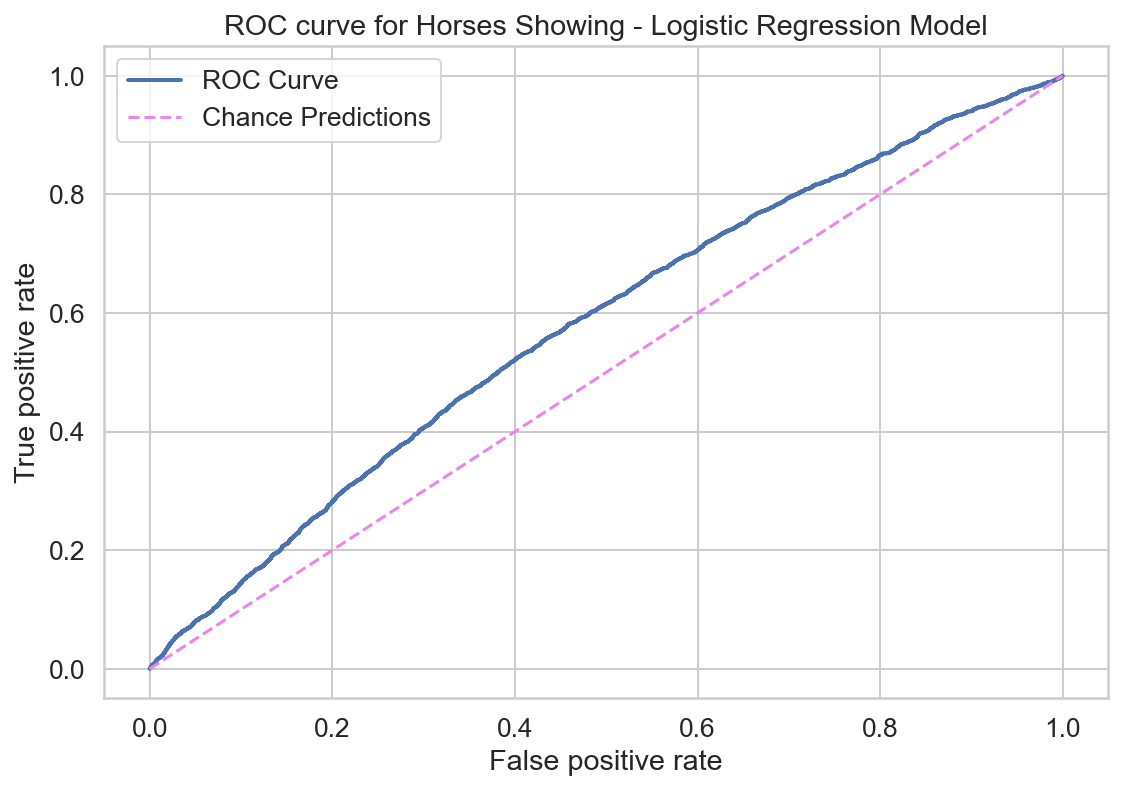

In [36]:
log_roc_curve_generator(X,y,C=1)

Based on the above precision-recall curve intersection, running the accuracy scorer with a 0.2 threshold, to start.

The accuracy score for logistic regression w/ threshold of 0.2403 is:
Validation set accuracy:  56.35%
Additional Model Metrics:
Validation Set F1 Score: 0.3787:
Validation Set Fbeta Score (beta=0.5): 0.3176
Validation set Precision: 0.2867
Validation set recall: 0.5573 

Validation set log-loss score: 15.0765
Confusion Matrix, Threshold = 0.2403


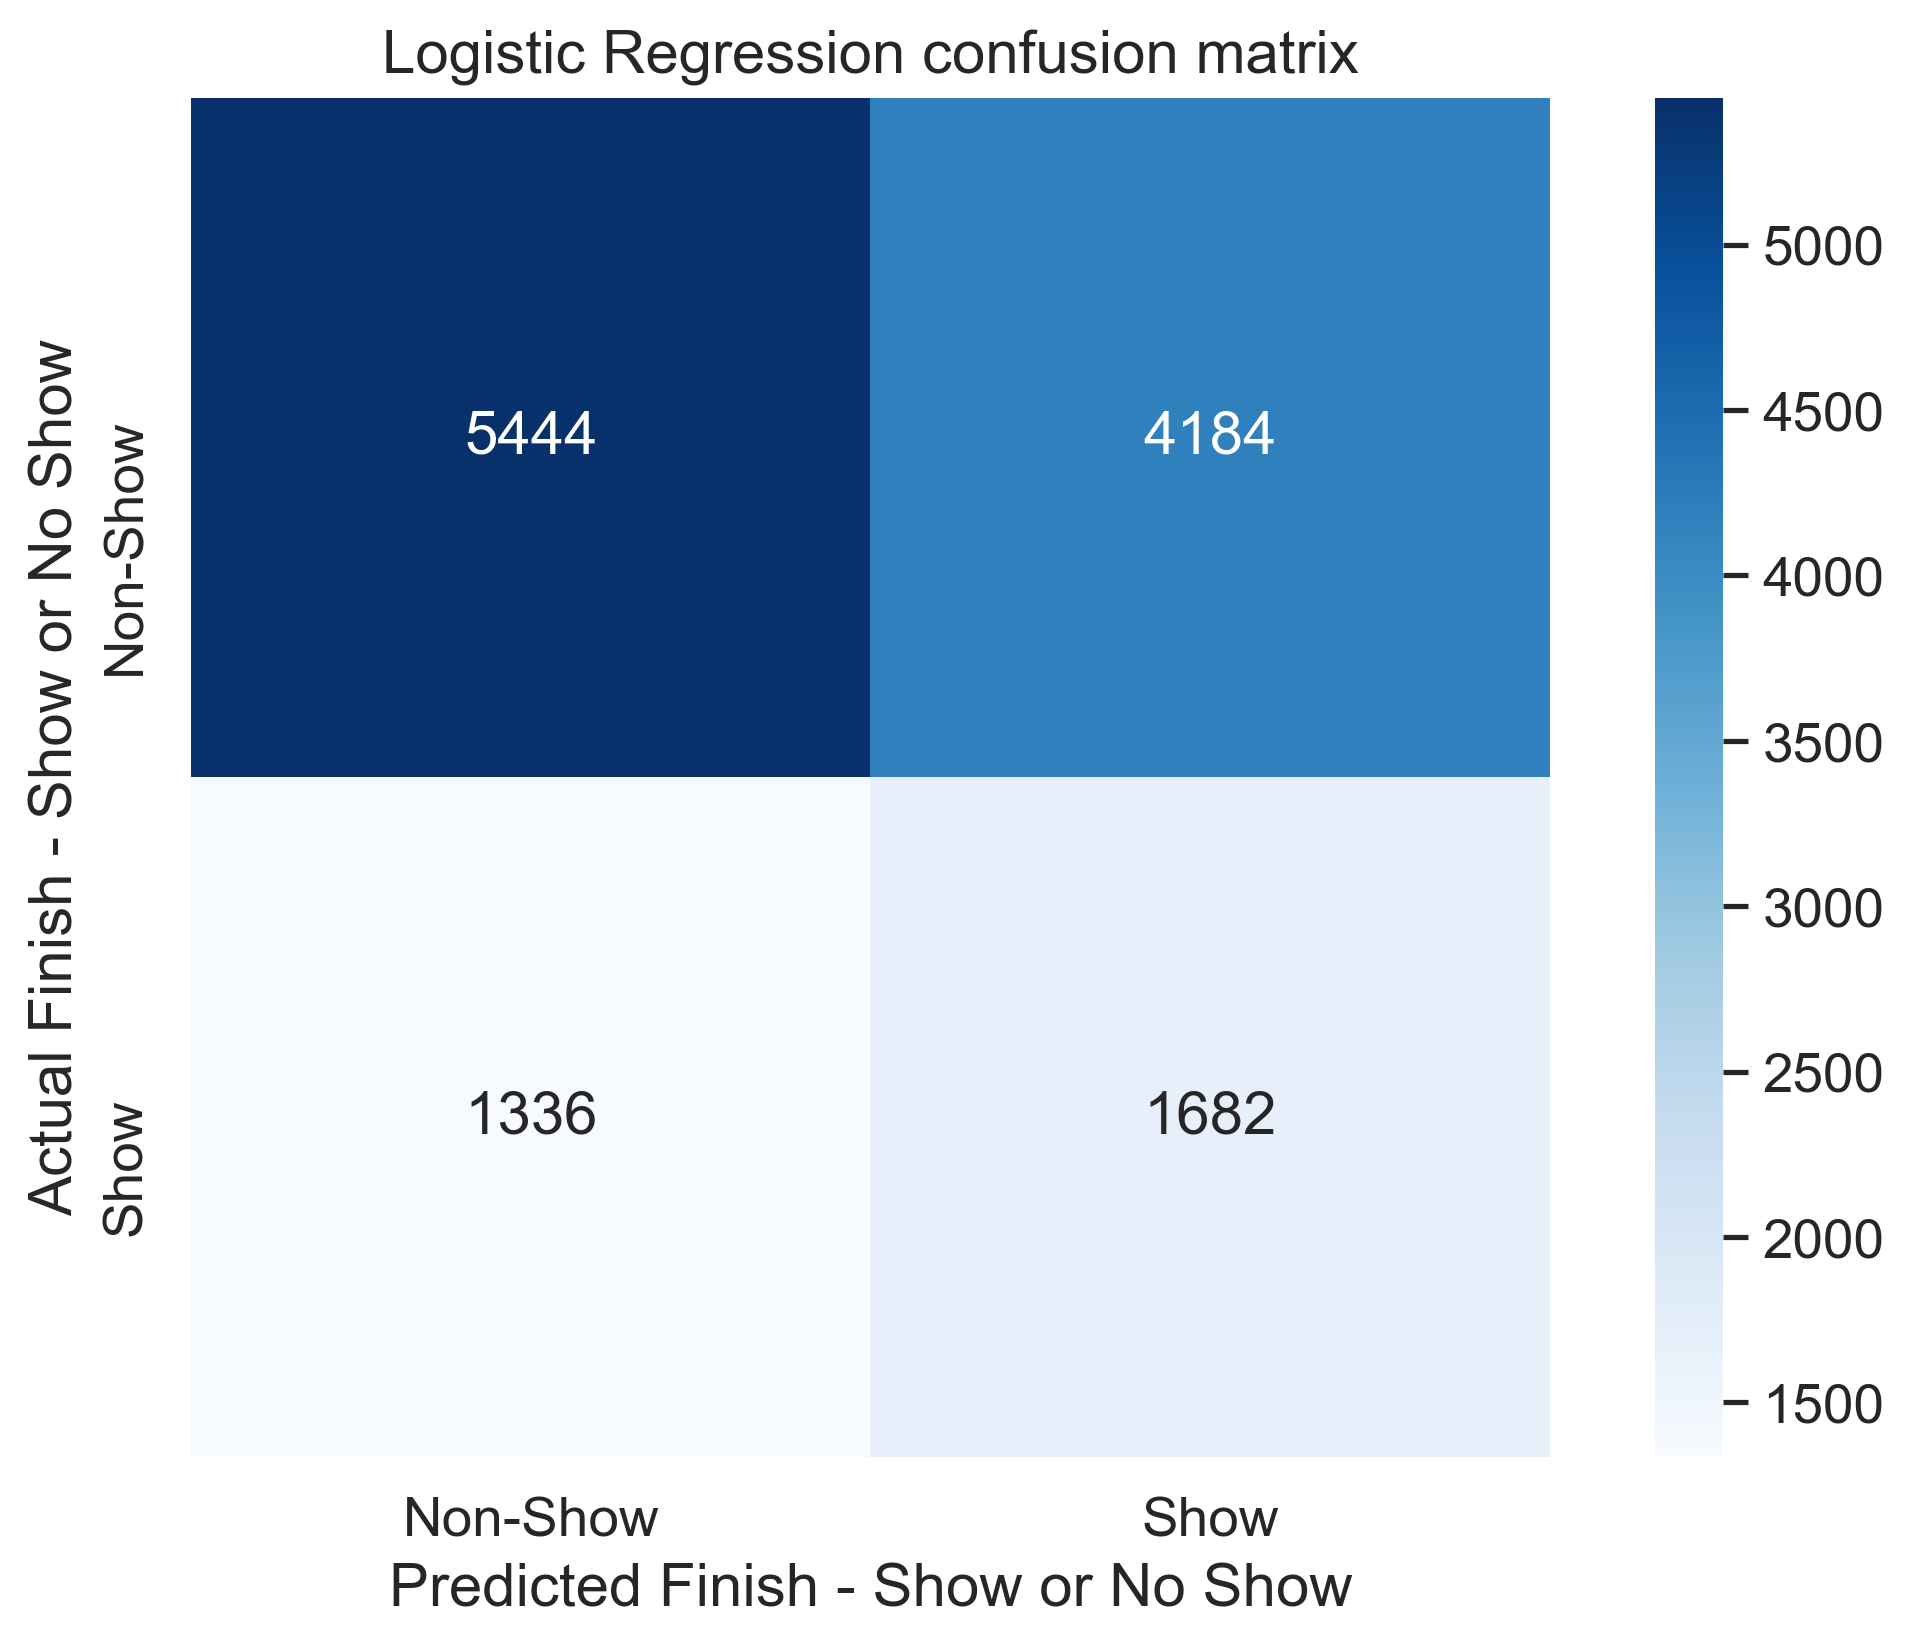

In [37]:
from sklearn.metrics import log_loss
log_accuracy_scorer(X, y, threshold=0.2403, C=11)

Overall, both the KNN and logistic regression models are not performing well when it comes to precision and recall.  I will need to try to improve these.  Accuracy is misleading, since the class imbalance of show vs. no show is relatively large.  

Conceptually, I believe precision is more important than recall due to the nature of gambling.  In other words, I would rather have a higher rate of predictions being right, since every wrong prediction means lost money.  I am going to add an Fbeta scorer for beta = 0.5 to all models, since this will weight precision more heavily than recall.

# MODEL 2 - KNN and Logistic Reg. w/ Oversampling of Minority Class (Show) Data

## Oversampling - Adding more of the Show class data:

My data has a roughly 76%-24% class imbalance, which makes sense (only the top 3 horses in any race can show).  Thus, I am going to try oversampling of the Show class, to account for this imbalance.

In [38]:
from sklearn.datasets import make_classification

Below needed to run to install packages, changing to markdown after initial installation:

*!pip install mlxtend*  
*!conda install -c conda-forge imbalanced-learn -y*

Printing the target class, to confirm the breakdown:

In [39]:
target_count = comb_training_model_gender.Show.value_counts()

In [40]:
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')

Class 0: 48138
Class 1: 15090
Proportion: 3.19 : 1
Percentage of Majority Class: 76.13


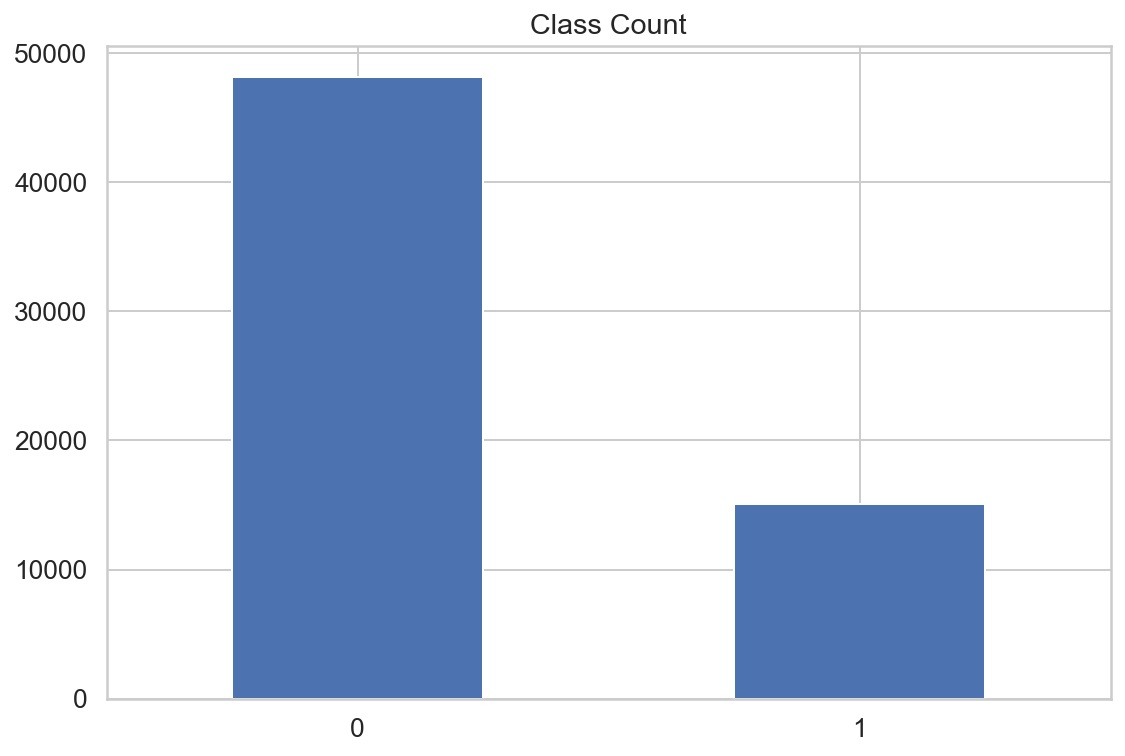

In [41]:
target_count.plot(kind='bar', title='Class Count', rot=0);

In [42]:
X = comb_training_model_gender[columns]
y = comb_training_model_gender['Show']

In [43]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X,y) 

In [44]:
from collections import Counter
Counter(y_resampled)

Counter({0: 48138, 1: 48138})

The accuracy score for kNN is
Training:  71.15%
Validation set:  62.26%
Validation Set F1 Score: 0.6442:
Validation Set Fbeta Score (beta=0.5): 0.6228
Validation set Precision: 0.6094
Validation set recall: 0.6832 



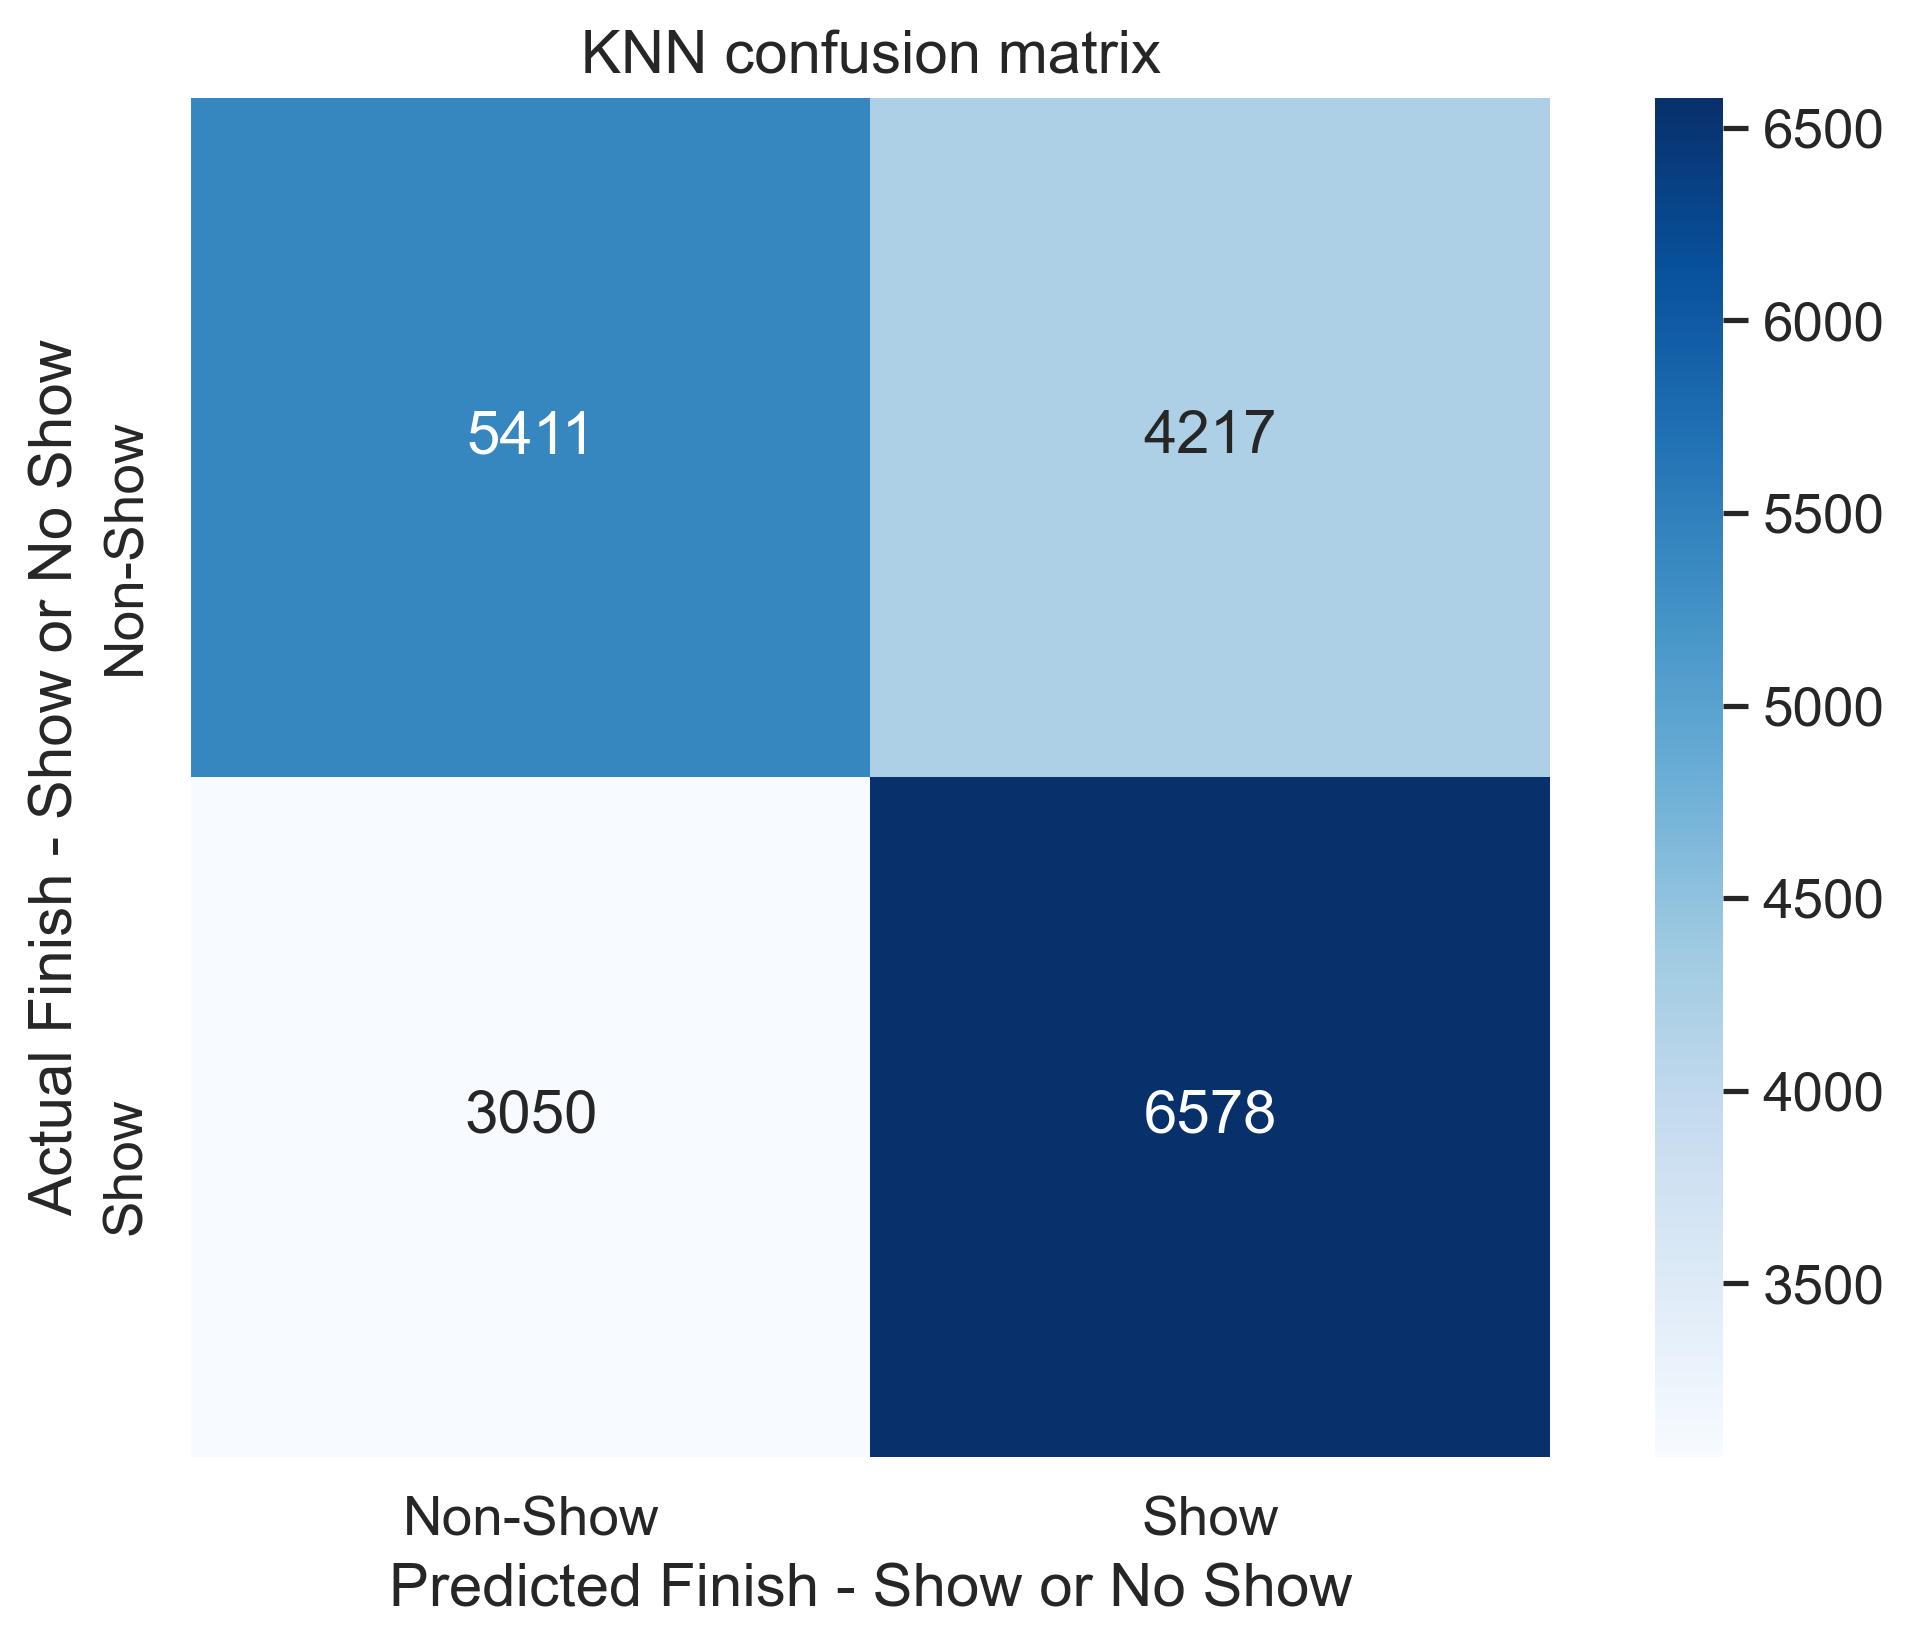

In [45]:
KNN_accuracy_scorer(X_resampled, y_resampled, n = 9)

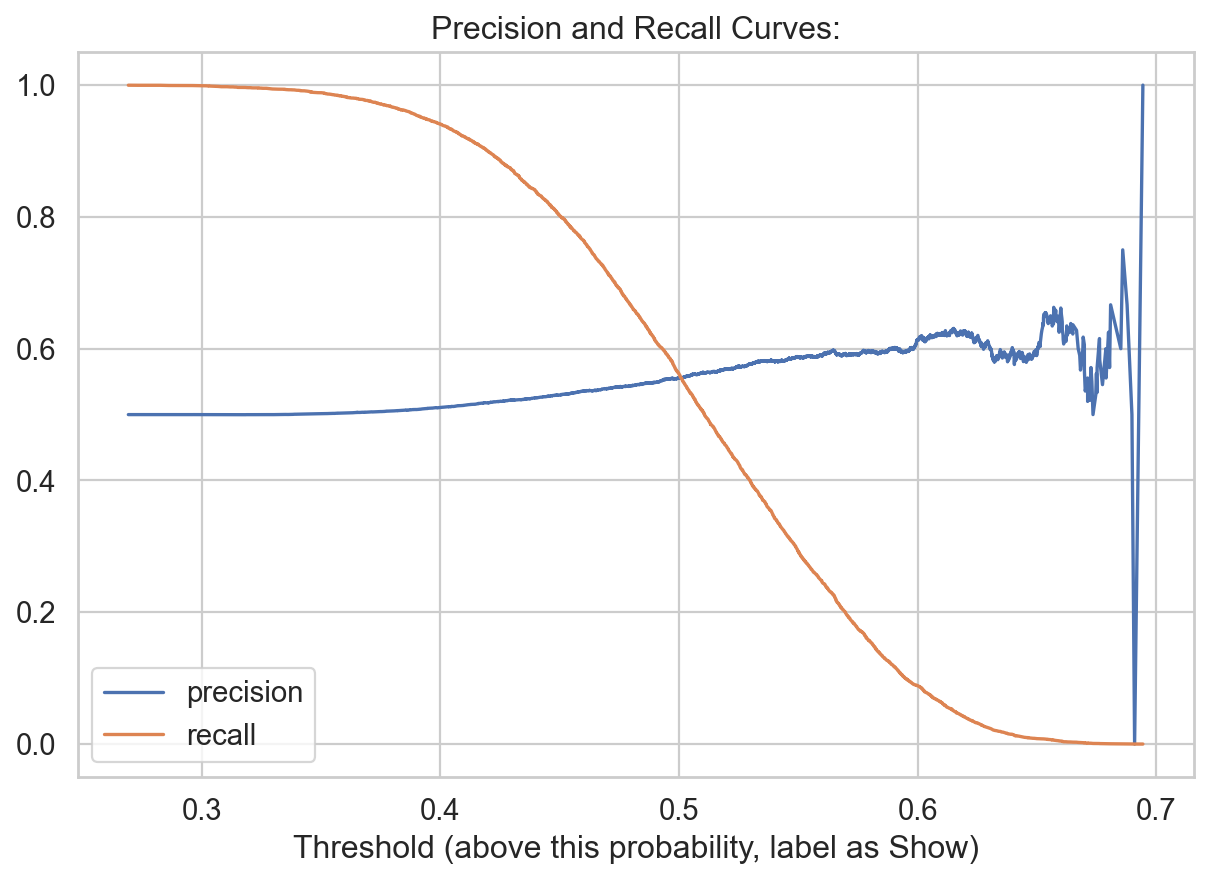

In [46]:
log_precision_and_recall_curves(X_resampled,y_resampled,C=1)

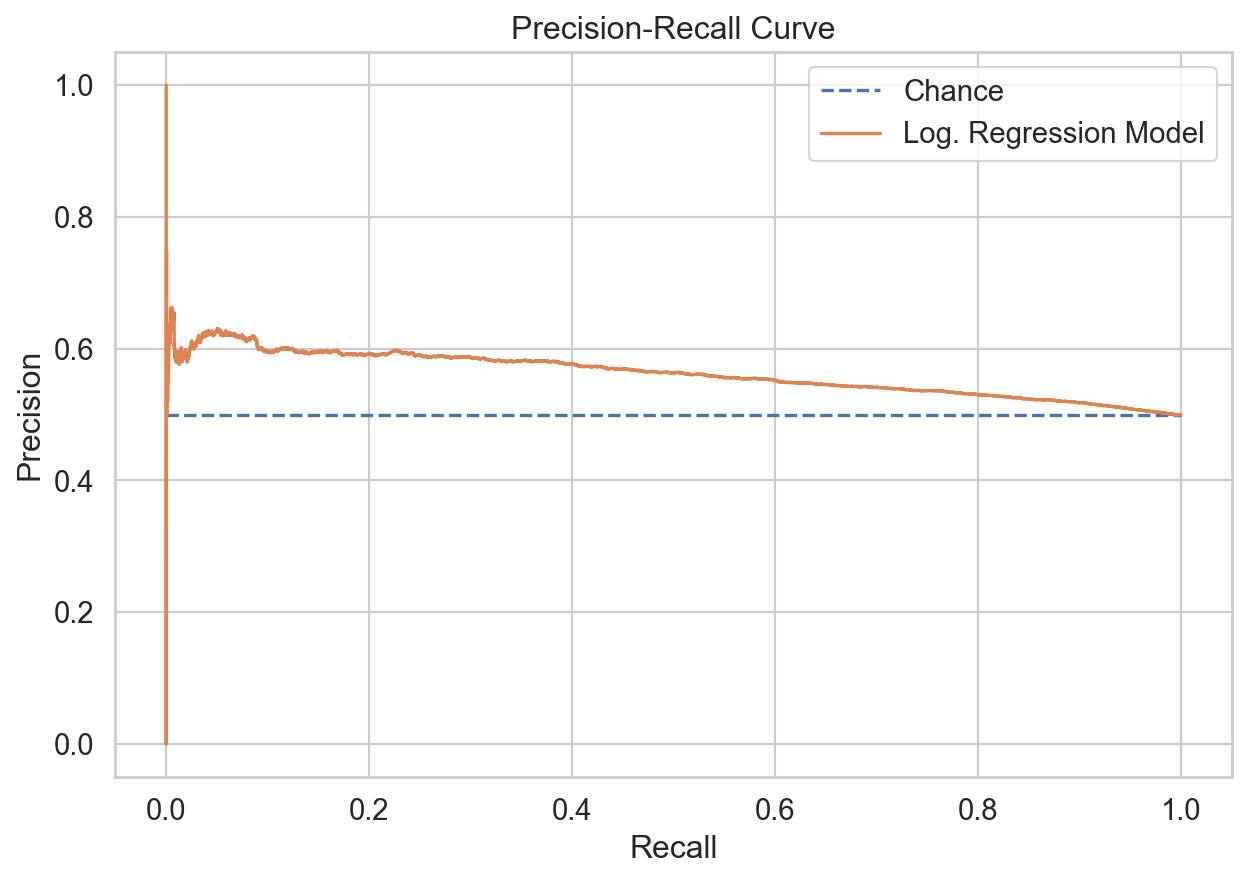

In [47]:
log_precision_recall_curve_generator(X_resampled,y_resampled,C=1)

ROC AUC score =  0.5781502512492558
Optimal Threshold: 0.4972
Threshold for Max Precision: 0.2692


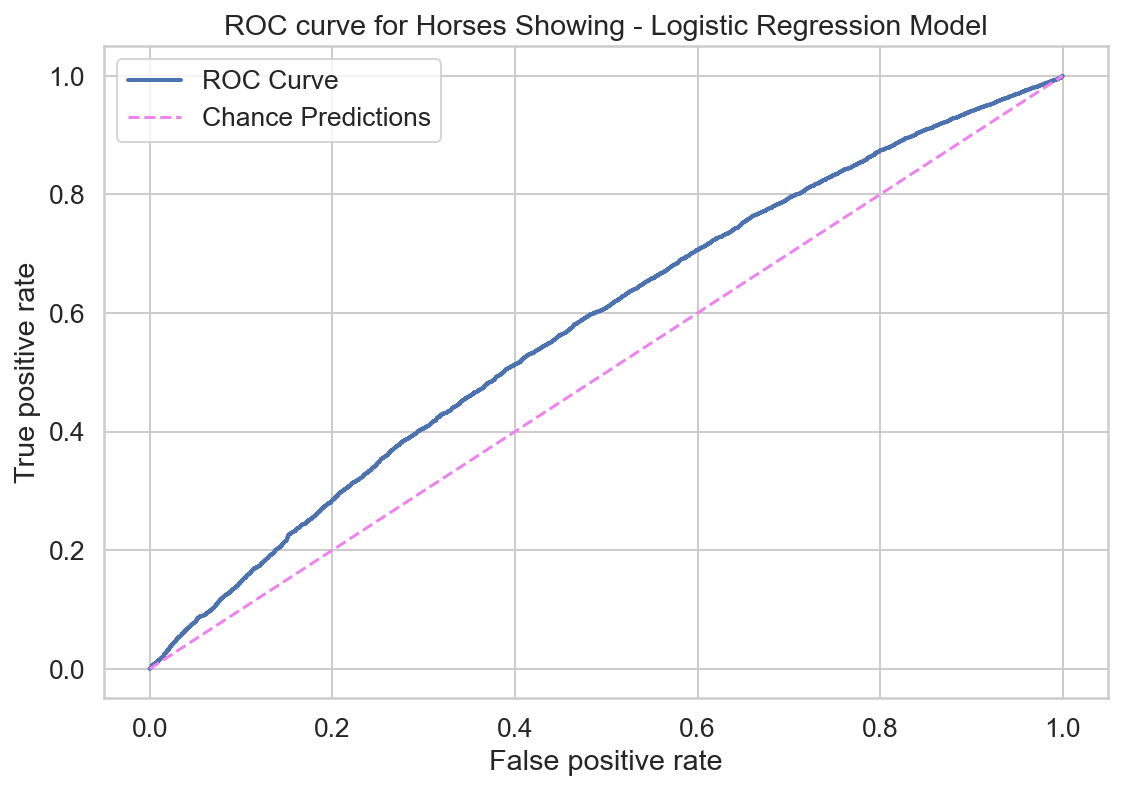

In [48]:
log_roc_curve_generator(X_resampled,y_resampled,C=1)

The accuracy score for logistic regression w/ threshold of 0.4972 is:
Validation set accuracy:  55.77%
Additional Model Metrics:
Validation Set F1 Score: 0.5675:
Validation Set Fbeta Score (beta=0.5): 0.5601
Validation set Precision: 0.5552
Validation set recall: 0.5804 

Validation set log-loss score: 15.2750
Confusion Matrix, Threshold = 0.4972


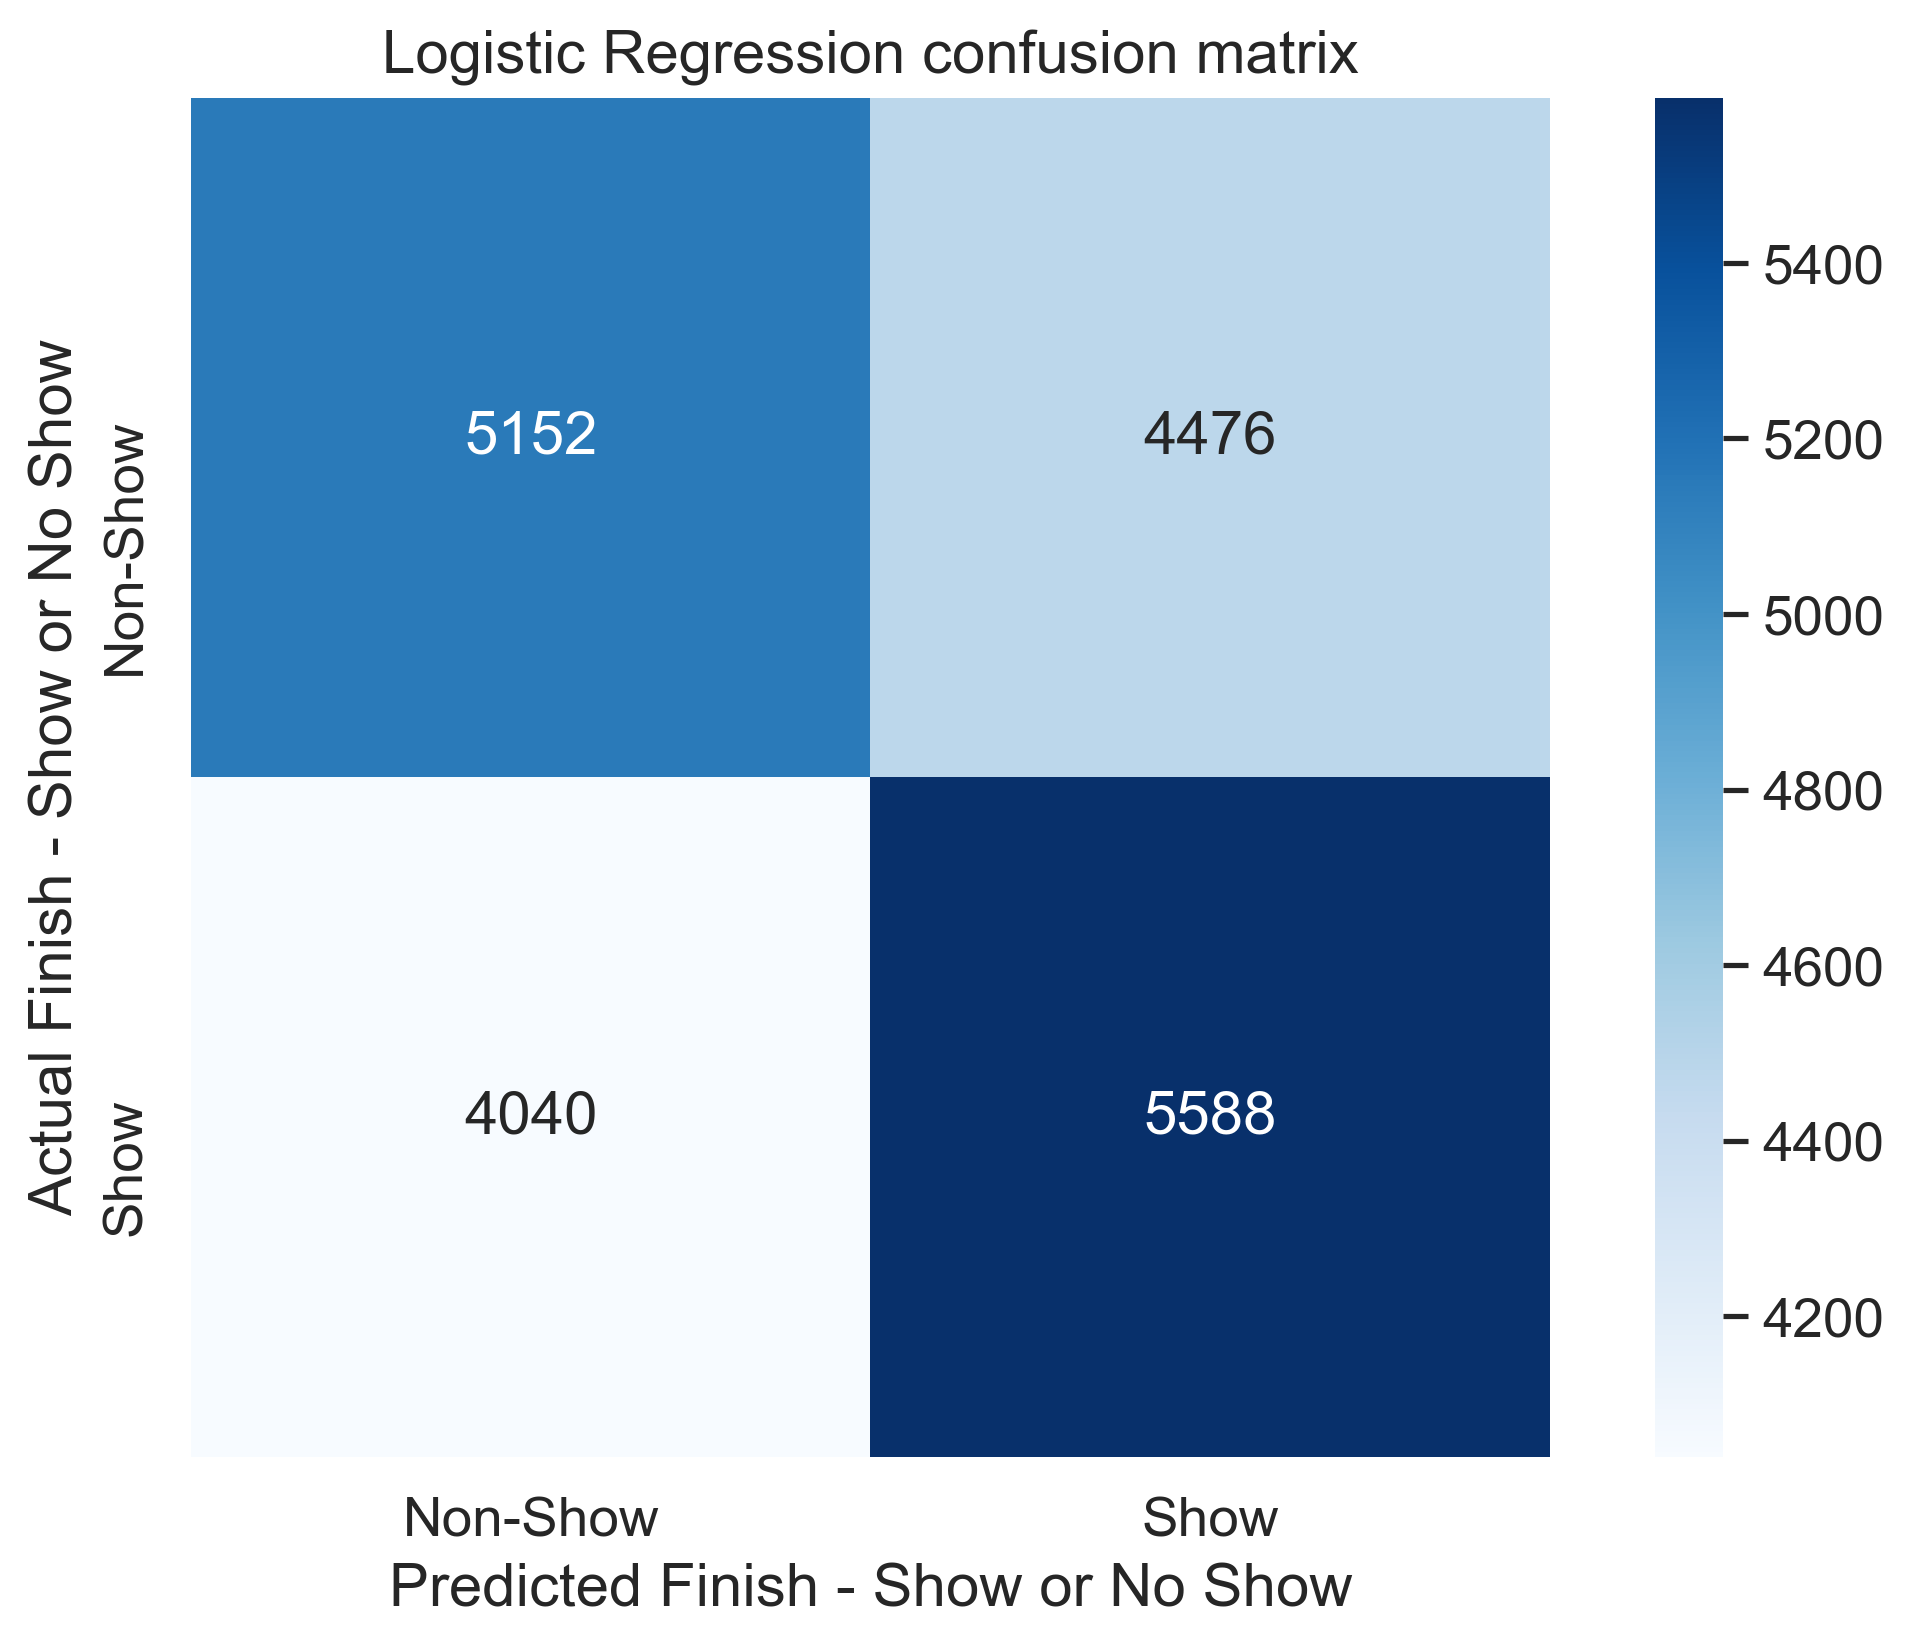

In [49]:
log_accuracy_scorer(X_resampled, y_resampled, threshold=0.4972, C=1)

That really increased my precision and recall, compared to not oversampling.  I think this will likely be the best way to go as the model progresses.